In [1]:
import json
import glob
import re
import pandas as pd
from os import path
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import math

data_dir = '../out'

In [2]:
all_files = glob.glob(path.join(data_dir, "gen_*.json"))
gen_pattern = 'gen_0*([0-9]*).json$'

def extract_gen_number(filename):
    return int(re.search(gen_pattern, filename).group(1))

all_files.sort(key=extract_gen_number)

In [15]:
particle_dfs_list = []
meta_dfs_list = []
for filename in all_files:
    gen_number = extract_gen_number(filename)
    
    with open(filename) as f:
        data = json.load(f)
    new_p_df = pd.json_normalize(data['pop'], record_path=['normalised_particles'])
    new_p_df['generation'] = gen_number

    meta = {
        'generation': gen_number, 
        'tolerance': data['pop']['tolerance'], 
        'acceptance': data['pop']['acceptance']
    }
    new_m_df = pd.DataFrame(data=meta, index=[gen_number])

    meta_dfs_list.append(new_m_df)
    particle_dfs_list.append(new_p_df)

particle_df = pd.concat(particle_dfs_list)
particle_df = particle_df.reset_index()

meta_df = pd.concat(meta_dfs_list)
meta_df = meta_df.reset_index()
meta_df = meta_df.drop('index', axis=1)
meta_df['generation'] = meta_df.generation.astype('category') 

print(meta_df.dtypes)
print(meta_df)

particle_df['mean_score'] = particle_df['scores'].map(mean)
df = particle_df.drop('scores', axis=1)

generation    category
tolerance      float64
acceptance     float64
dtype: object
   generation      tolerance  acceptance
0           1  1.797693e+308    1.000000
1           2   4.514583e-01    0.802568
2           3   3.025000e-01    0.851789
3           4   2.350000e-01    0.888099
4           5   2.000000e-01    0.884173
5           6   1.700000e-01    0.874126
6           7   1.350000e-01    0.883392
7           8   1.189583e-01    0.863558
8           9   1.050000e-01    0.871840
9          10   9.500000e-02    0.869565
10         11   8.750000e-02    0.845309
11         12   8.500000e-02    0.832639
12         13   8.250000e-02    0.868810
13         14   8.500000e-02    0.859845
14         15   8.000000e-02    0.827815


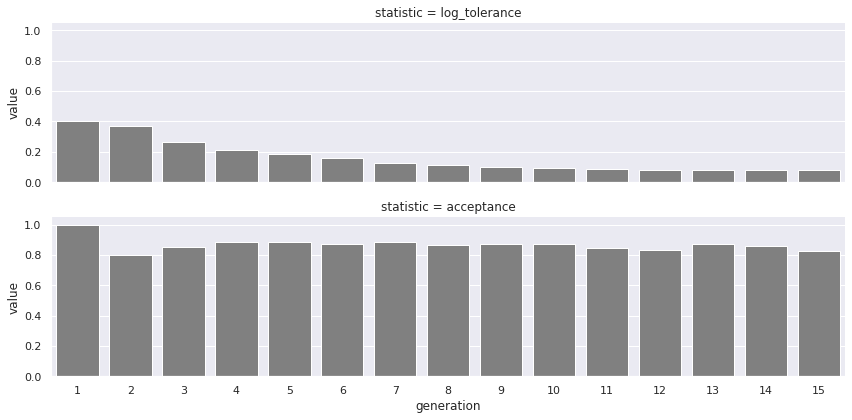

In [26]:
meta_df['log_tolerance'] = meta_df['tolerance'].map(lambda x: math.log(1 + min(x, 0.5)))
meta_melt = meta_df.melt('generation', var_name='statistic', value_vars=['log_tolerance', 'acceptance'])

sns.FacetGrid(
    meta_melt, 
    row="statistic",
    aspect=4,
).map_dataframe(
    sns.barplot,
    x='generation', 
    y='value',
    color='grey'
)


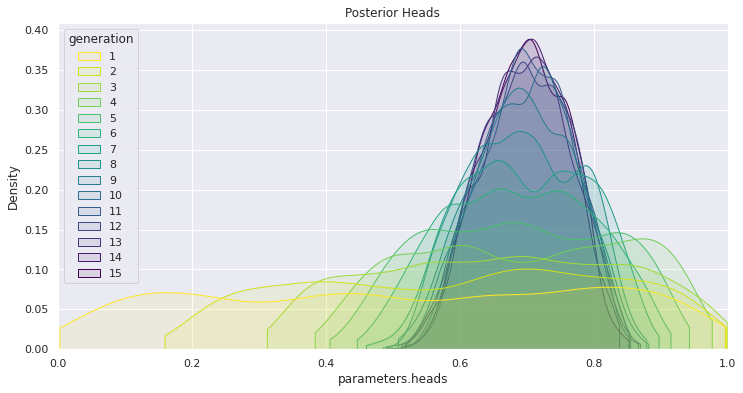

In [5]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(0, 1)

sns.kdeplot(
   data=particle_df, 
   x="parameters.heads", 
   hue='generation',
   fill=True, 
   palette="viridis_r",
   alpha=.1, 
   linewidth=1,
   bw_adjust=.8, 
   cut=0, 
).set(title='Posterior Heads')
sns.move_legend(ax, "upper left")

[Text(0.5, 1.0, 'Mean Score Distribution')]

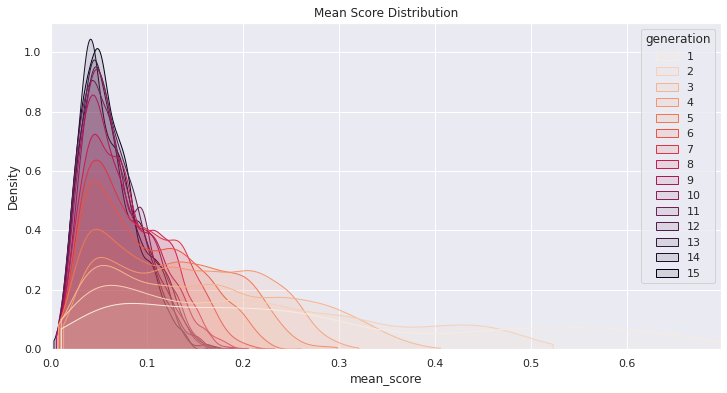

In [6]:
#sns.set_theme()
fig, ax = plt.subplots(figsize=(12,6))
score_max = max(particle_df['mean_score'])
ax.set_xlim(0, score_max)
sns.kdeplot(
    data=particle_df, 
    x='mean_score', 
    hue='generation',
    fill=True, 
    palette="rocket_r",
    alpha=.1, 
    linewidth=1,
    bw_adjust=.8, 
    cut=0,
).set(title='Mean Score Distribution')